In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygrib as pgr
from PIL import Image
import datetime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

#Do something else for this
SaveFileName = 'OverviewTest.png'
NewSaveFileName = 'OverviewTest_optimized.png'
NewSaveFileName2 = 'OverviewTest_optimized_2.png'



#Do something else for this
Filename = 'harmonie-data/NEAData/NEA_2023032709.001'
# Filename = 'harmonie-data/NEAData/NEA_2023040409.001'


grbs = pgr.open(Filename)

y, x = grbs.message(191).latlons() #regular lat/lon
u10=grbs.message(191).values
v10=grbs.message(197).values
windspeed=np.sqrt(u10**2+v10**2)
c1=grbs.message(215).values
c2=grbs.message(216).values
c3=grbs.message(217).values
t2=grbs.message(181).values-273.15
precip=grbs.message(210).values
snow=grbs.message(225).values
mslp=grbs.message(1).values/100
temp850 = grbs.message(129).values-273.15
visibility = grbs.message(190).values
dewpoint = grbs.message(189).values
maxtemp = grbs.message(187).values-273.15
mintemp = grbs.message(188).values-273.15

#Adjusting wind angles
#a, b, and c-side of the triangle
angle = np.ones((386,466))
lon_s = 25
lat_s = -60

#canculating angles
for i in range(386):
    for j in range(466):
        SB = np.sin(np.radians(x[i,j]-lon_s))*np.cos(np.radians(lat_s))
        CB = -np.sin(np.radians(lat_s))*np.cos(np.radians(y[i,j]))+np.cos(np.radians(lat_s))*np.sin(np.radians(y[i,j]))*np.cos(np.radians(x[i,j]-lon_s))
        angle[i,j] = np.rad2deg(np.arctan2(SB,CB))

#adjusting wind-direction with the b-angle
# The constant -9 has to be removed when we figure out how to adjust the angle correctly
direction=np.mod(180+np.rad2deg(np.arctan2(u10, v10)) + angle - 9,360)

#adjusted 10-meter wind speeds (u and v)
u11 = np.sin(np.radians(direction))*windspeed*(-1)
v11 = np.cos(np.radians(direction))*windspeed*(-1)
uquiver = u11 / np.sqrt(u11 ** 2 + v11 ** 2) * 10
vquiver = v11 / np.sqrt(u11 ** 2 + v11 ** 2) * 10



In [2]:


def save_optimized_image(SaveFileName):
    try:
        with Image.open(SaveFileName) as im:
            im_width, im_height = im.size
            im_resize = im.resize((im_width // 3, im_height // 3))

            im_rgb = im_resize.convert('RGB')
            im_rgb.save(f"{NewSaveFileName}", optimize=True, quality=70)
            im_rgb.save(f"{NewSaveFileName2}", optimize=True, quality=70)
    except OSError as e:
        print(e)
        pass

    
    


# from helpers import save_optimized_image


def generate_waters_plot(y, x):
    plot = Basemap(
        resolution='l',
        projection='stere',
        lat_0=62,
        lon_0=353,
        llcrnrlat=58.4,
        llcrnrlon=-16.41,
        urcrnrlat=65,
        urcrnrlon=3,
    )
    
    plot.drawcoastlines()
    plot.readshapefile('shapefiles/Oyggjar', 'Oyggjar')
    plot.readshapefile('shapefiles/Ytribanki', 'Ytribanki',color='blue')
    plot.readshapefile('shapefiles/Munkagrunnur', 'Munkagrunnur',color='blue')
    plot.readshapefile('shapefiles/Fugloyarbanki', 'Fugloyarbanki',color='blue')
    plot.readshapefile('shapefiles/Islandsryggur', 'Islandsryggur',color='blue')
    plot.readshapefile('shapefiles/Fiskimark1','Fiskimark1',color='red')
    plot.readshapefile('shapefiles/Fiskimark2','Fiskimark2',color='red')
    return plot(x, y)

# # define latitude and longitude bounds of the selected region
# lat1 = 58.4
# lat2 = 65#<maximum latitude>
# lon1 = -16.41#<minimum longitude>
# lon2 = 3#<maximum longitude>

# # find the indices of the selected region
# lat_indices = (lats >= lat1) & (lats <= lat2)
# lon_indices = (lons >= lon1) & (lons <= lon2)
# lonlat_indices = (lats >= lat1) & (lats <= lat2) & (lons >= lon1) & (lons <= lon2)

# windspeed2 = windspeed[lonlat_indices]

# data_region = data[lonlat_indices]
# lats_region = lats[lonlat_indices]
# lons_region = lons[lonlat_indices]

In [128]:
def plot_wind(y, x, windspeed, uquiver, vquiver, mslp, SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    wind_lons, wind_lats = generate_waters_plot(y, x)

    levels = [0, 3.3, 5.4, 7.9, 10.7, 13.8, 17.1, 20.7, 24.4, 28.4, 32.6]

    colorstring=[
        '#e1e1e1',
        '#afafc8',
        '#7d7dc8',
        '#4bc8c8',
        '#4bc84b',
        '#c8c84b',
        '#c89632',
        '#c86432',
        '#c83232',
        '#c83296',
        '#9664c8'
    ]

    contour0 = ax.contourf(wind_lons, wind_lats, windspeed, levels=levels,colors=colorstring)
    k = 8
    ax.quiver(
        wind_lons[::k, ::k],
        wind_lats[::k, ::k],
        uquiver[::k, ::k],
        vquiver[::k, ::k],
        color="black",
        scale_units='inches',
        scale=85,
        width=0.0010,
        pivot='mid'
    )
    
# #Attempted to display windspeed numbers. It became an ugly solution, but it works..
    ilen = np.floor_divide(386,k)
    jlen = np.floor_divide(386,k)

    for i in range(1,ilen-23):
        
        for j in range(40,jlen):
            plt.text(wind_lons[i*k+4, j*k], wind_lats[i*k+4, j*k], round(windspeed[i*k, j*k],1),fontsize=5, ha='center', va='center', color='black')

    for i in range(1,ilen-20):
        
        for j in range(35,jlen-(jlen-40)):
            plt.text(wind_lons[i*k+4, j*k], wind_lats[i*k+4, j*k], round(windspeed[i*k, j*k],1),fontsize=5, ha='center', va='center', color='black')
            
    for i in range(1,ilen-18):
        
        for j in range(25,jlen-(jlen-35)):
            plt.text(wind_lons[i*k+4, j*k], wind_lats[i*k+4, j*k], round(windspeed[i*k, j*k],1),fontsize=5, ha='center', va='center', color='black')

    for i in range(1,ilen-15):
        
        for j in range(15,jlen-(jlen-25)):
            plt.text(wind_lons[i*k+4, j*k], wind_lats[i*k+4, j*k], round(windspeed[i*k, j*k],1),fontsize=5, ha='center', va='center', color='black')
            
    for i in range(5,ilen-15):
        
        for j in range(7,jlen-(jlen-15)):
            plt.text(wind_lons[i*k+4, j*k], wind_lats[i*k+4, j*k], round(windspeed[i*k, j*k],1),fontsize=5, ha='center', va='center', color='black')            

            
    levels = range(800,1100,4)
    contour3 = ax.contour(wind_lons,wind_lats,mslp,levels=levels,colors='black')
    
    ax.axis('off')

    #Printing Colorbar
    cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.2, fraction=0.021, shrink=0.3, orientation='horizontal')
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Vindur (m/s)',size=10)
    
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=1, fontsize=12,inline_spacing=100)
    
    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)

def plot_overview(y, x, precip, snow, c1, c2, c3, mslp,temp850,SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    #Plotting clouds
    
    levels = [-0.01, 35, 55, 70, 95, 101]
    
    #Low Clouds
    colorstring3=['#daf0ff','#d2d2d2', '#b4b4b4', '#8c8c8c', '#646464']
    contour0 = ax.contourf(lons, lats, c1*100, levels=levels, colors=colorstring3)
    
    #Plotting rain
    levels = [0.08, 0.17, 0.33, 0.83, 1.67, 4, 8, 15]
    colorstring=['#8589ff', '#8589ff', '#7275db', '#6568c7', '#4c4fad', '#dbbf6b', '#f5e767']
    contour1 = ax.contourf(lons, lats, precip, levels=levels, colors=colorstring)

    
    #Plotting snow
    levels = [0.17, 0.33, 0.83, 1.67, 2.5, 10]
    colorstring=['#e6d0f2', '#c091d9', '#9a63b8', '#7c419c', '#750c42']
    contour2 = ax.contourf(lons, lats, snow, levels=levels, colors=colorstring)

    levels = range(800,1100,4)
    contour3 = ax.contour(lons,lats,mslp,levels=levels,colors='black')
    
    
    #Plotting airmass temperature in different color intervals
    levels = range(-40,-6,2)
    contour4 = ax.contour(lons,lats,temp850,levels=levels,colors='#3232e1',linestyles='solid')
    
    levels = [-4, -2, 0]
    contour5 =ax.contour(lons,lats,temp850,levels=levels,colors='#960096',linestyles='solid')
    
    levels = range(2,40,2)
    contour6 =ax.contour(lons,lats,temp850,levels=levels,colors='#e13232',linestyles='solid')
    
    
    ax.axis('off')
    
    
    
    cbar2 = plt.colorbar(contour2, ax=ax, extend="neither",location="right", pad=-0.07, fraction=0.021, shrink=0.3, orientation='vertical')
    cbar2.ax.set_yticklabels([0.17, 0.33, 0.83, 1.67, 2.5, 10])
    cbar2.ax.tick_params(labelsize=10)
    cbar2.set_label(label='Kavi (cm/t)',size=10)

    cbar1 = plt.colorbar(contour1, ax=ax, extend="neither",location="right", pad=-0.47, fraction=0.021, shrink=0.3, orientation='vertical')
    cbar1.ax.set_yticklabels([0.08, 0.17, 0.33, 0.83, 1.67, 4, 8, 15])
    cbar1.ax.tick_params(labelsize=10)
    cbar1.set_label(label='Regn (mm/t)',size=10)
    
    #Drawing the colormap of low clouds
    cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.2, fraction=0.021, shrink=0.3, orientation='horizontal')
    cbar.ax.set_xticklabels(['0', '10', '25', '50', '75', '100'])
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Skýloft (%)',size=10)
    
    #Placing text on contour labels
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=1, fontsize=12,inline_spacing=100)
    contourlabel2 = ax.clabel(contour4, contour4.levels, inline=1, fontsize=12,inline_spacing=75)
    contourlabel3 = ax.clabel(contour5, contour5.levels, inline=1, fontsize=12,inline_spacing=75)
    contourlabel4 = ax.clabel(contour6, contour6.levels, inline=1, fontsize=12,inline_spacing=75)

    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)

def plot_clouds(y, x, c1, c2, c3, mslp,temp850,SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    
    #Plotting clouds
    
    #High clouds
    levels = [-0.01, 25, 35, 70, 90, 101]
    colorstring1=['#daf0ff', '#c7c7ff', '#aeaefc', '#9696fa', '#5454ff']
    ax.contourf(lons, lats, c3*100, levels=levels, colors=colorstring1,alpha=0.7)
    
    levels = [35, 55, 70, 95, 101]
    
    #Medium Clouds
    colorstring2=['#c7fa9b', '#b9fa50', '#82fa19', '#7efa19']    
    ax.contourf(lons, lats, c2*100, levels=levels, colors=colorstring2,alpha=0.8)
    
    #Low Clouds
    colorstring3=['#d2d2d2', '#b4b4b4', '#8c8c8c', '#646464']
    contour0 = ax.contourf(lons, lats, c1*100, levels=levels, colors=colorstring3)

    levels = range(800,1100,4)
    contour3 = ax.contour(lons,lats,mslp,levels=levels,colors='black')
    
    
    #Plotting airmass temperature in different color intervals
    levels = range(-40,-6,2)
    contour4 = ax.contour(lons,lats,temp850,levels=levels,colors='#3232e1',linestyles='solid')
    
    levels = [-4, -2, 0]
    contour5 =ax.contour(lons,lats,temp850,levels=levels,colors='#960096',linestyles='solid')
    
    levels = range(2,40,2)
    contour6 =ax.contour(lons,lats,temp850,levels=levels,colors='#e13232',linestyles='solid')
    
    
    ax.axis('off')
    
    #Drawing the colormap of low clouds
    cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.2, fraction=0.021, shrink=0.3, orientation='horizontal')
    cbar.ax.set_xticklabels(['10', '25', '50', '75', '100'])
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Skýloft (%)',size=10)
    
    #Placing text on contour labels
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=True, fontsize=12,inline_spacing=100)
    contourlabel2 = ax.clabel(contour4, contour4.levels, inline=True, fontsize=12,inline_spacing=75)
    contourlabel3 = ax.clabel(contour5, contour5.levels, inline=True, fontsize=12,inline_spacing=75)
    contourlabel4 = ax.clabel(contour6, contour6.levels, inline=True, fontsize=12,inline_spacing=75)

    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)

def plot_precipitation(y, x, precip, snow, mslp,temp850,SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    
    #Plotting rain
    levels = [-0.01, 0.08, 0.17, 0.33, 0.83, 1.67, 4, 8, 15]
    colorstring=['#daf0ff','#8589ff', '#8589ff', '#7275db', '#6568c7', '#4c4fad', '#dbbf6b', '#f5e767']
    contour1 = ax.contourf(lons, lats, precip, levels=levels, colors=colorstring)

    
    #Plotting snow
    levels = [0.17, 0.33, 0.83, 1.67, 2.5, 10]
    colorstring=['#e6d0f2', '#c091d9', '#9a63b8', '#7c419c', '#750c42']
    contour2 = ax.contourf(lons, lats, snow, levels=levels, colors=colorstring)

    levels = range(800,1100,4)
    contour3 = ax.contour(lons,lats,mslp,levels=levels,colors='black')
    
    
    #Plotting airmass temperature in different color intervals
    levels = range(-40,-6,2)
    contour4 = ax.contour(lons,lats,temp850,levels=levels,colors='#3232e1',linestyles='solid')
    
    levels = [-4, -2, 0]
    contour5 =ax.contour(lons,lats,temp850,levels=levels,colors='#960096',linestyles='solid')
    
    levels = range(2,40,2)
    contour6 =ax.contour(lons,lats,temp850,levels=levels,colors='#e13232',linestyles='solid')
    
    
    ax.axis('off')
    
    
    
    cbar2 = plt.colorbar(contour2, ax=ax, extend="neither",location="right", pad=-0.07, fraction=0.021, shrink=0.3, orientation='vertical')
    cbar2.ax.set_yticklabels([0.17, 0.33, 0.83, 1.67, 2.5, 10])
    cbar2.ax.tick_params(labelsize=10)
    cbar2.set_label(label='Kavi (cm/t)',size=10)

    cbar1 = plt.colorbar(contour1, ax=ax, extend="neither",location="right", pad=-0.05, fraction=0.021, shrink=0.3, orientation='vertical')
    cbar1.ax.set_yticklabels([0, 0.08, 0.17, 0.33, 0.83, 1.67, 4, 8, 15])
    cbar1.ax.tick_params(labelsize=10)
    cbar1.set_label(label='Regn (mm/t)',size=10)
    
    #Placing text on contour labels
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=True, fontsize=12,inline_spacing=100)
    contourlabel2 = ax.clabel(contour4, contour4.levels, inline=True, fontsize=12,inline_spacing=75)
    contourlabel3 = ax.clabel(contour5, contour5.levels, inline=True, fontsize=12,inline_spacing=75)
    contourlabel4 = ax.clabel(contour6, contour6.levels, inline=True, fontsize=12,inline_spacing=75)

    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)
    
def plot_visibility(y, x, visibility, mslp,SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    
    #Plotting visibility
    levels = [-0.01, 1000, 4000, 8000, 999999999999]
    colorstring1=['#464646','#964b96', '#e8e248','#daf0ff']
    contour0 = ax.contourf(lons, lats, visibility, levels=levels, colors=colorstring1)
    
    #Plotting pressure
    levels = range(800,1100,4)
    contour3 = ax.contour(lons,lats,mslp,levels=levels,colors='black')
        
    ax.axis('off')
    
    #Drawing the colormap of low clouds
    cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.22, fraction=0.021, shrink=0.3, orientation='horizontal')
    cbar.ax.set_xticklabels(['0km','1km', '4km', '8km', 'Gott sýni'])
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Sýni',size=10)
    
    #Placing text on contour labels
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=True, fontsize=12,inline_spacing=100)


    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)

/tmp/ipykernel_259/1734611881.py:75: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.2, fraction=0.021, shrink=0.3, orientation='horizontal')


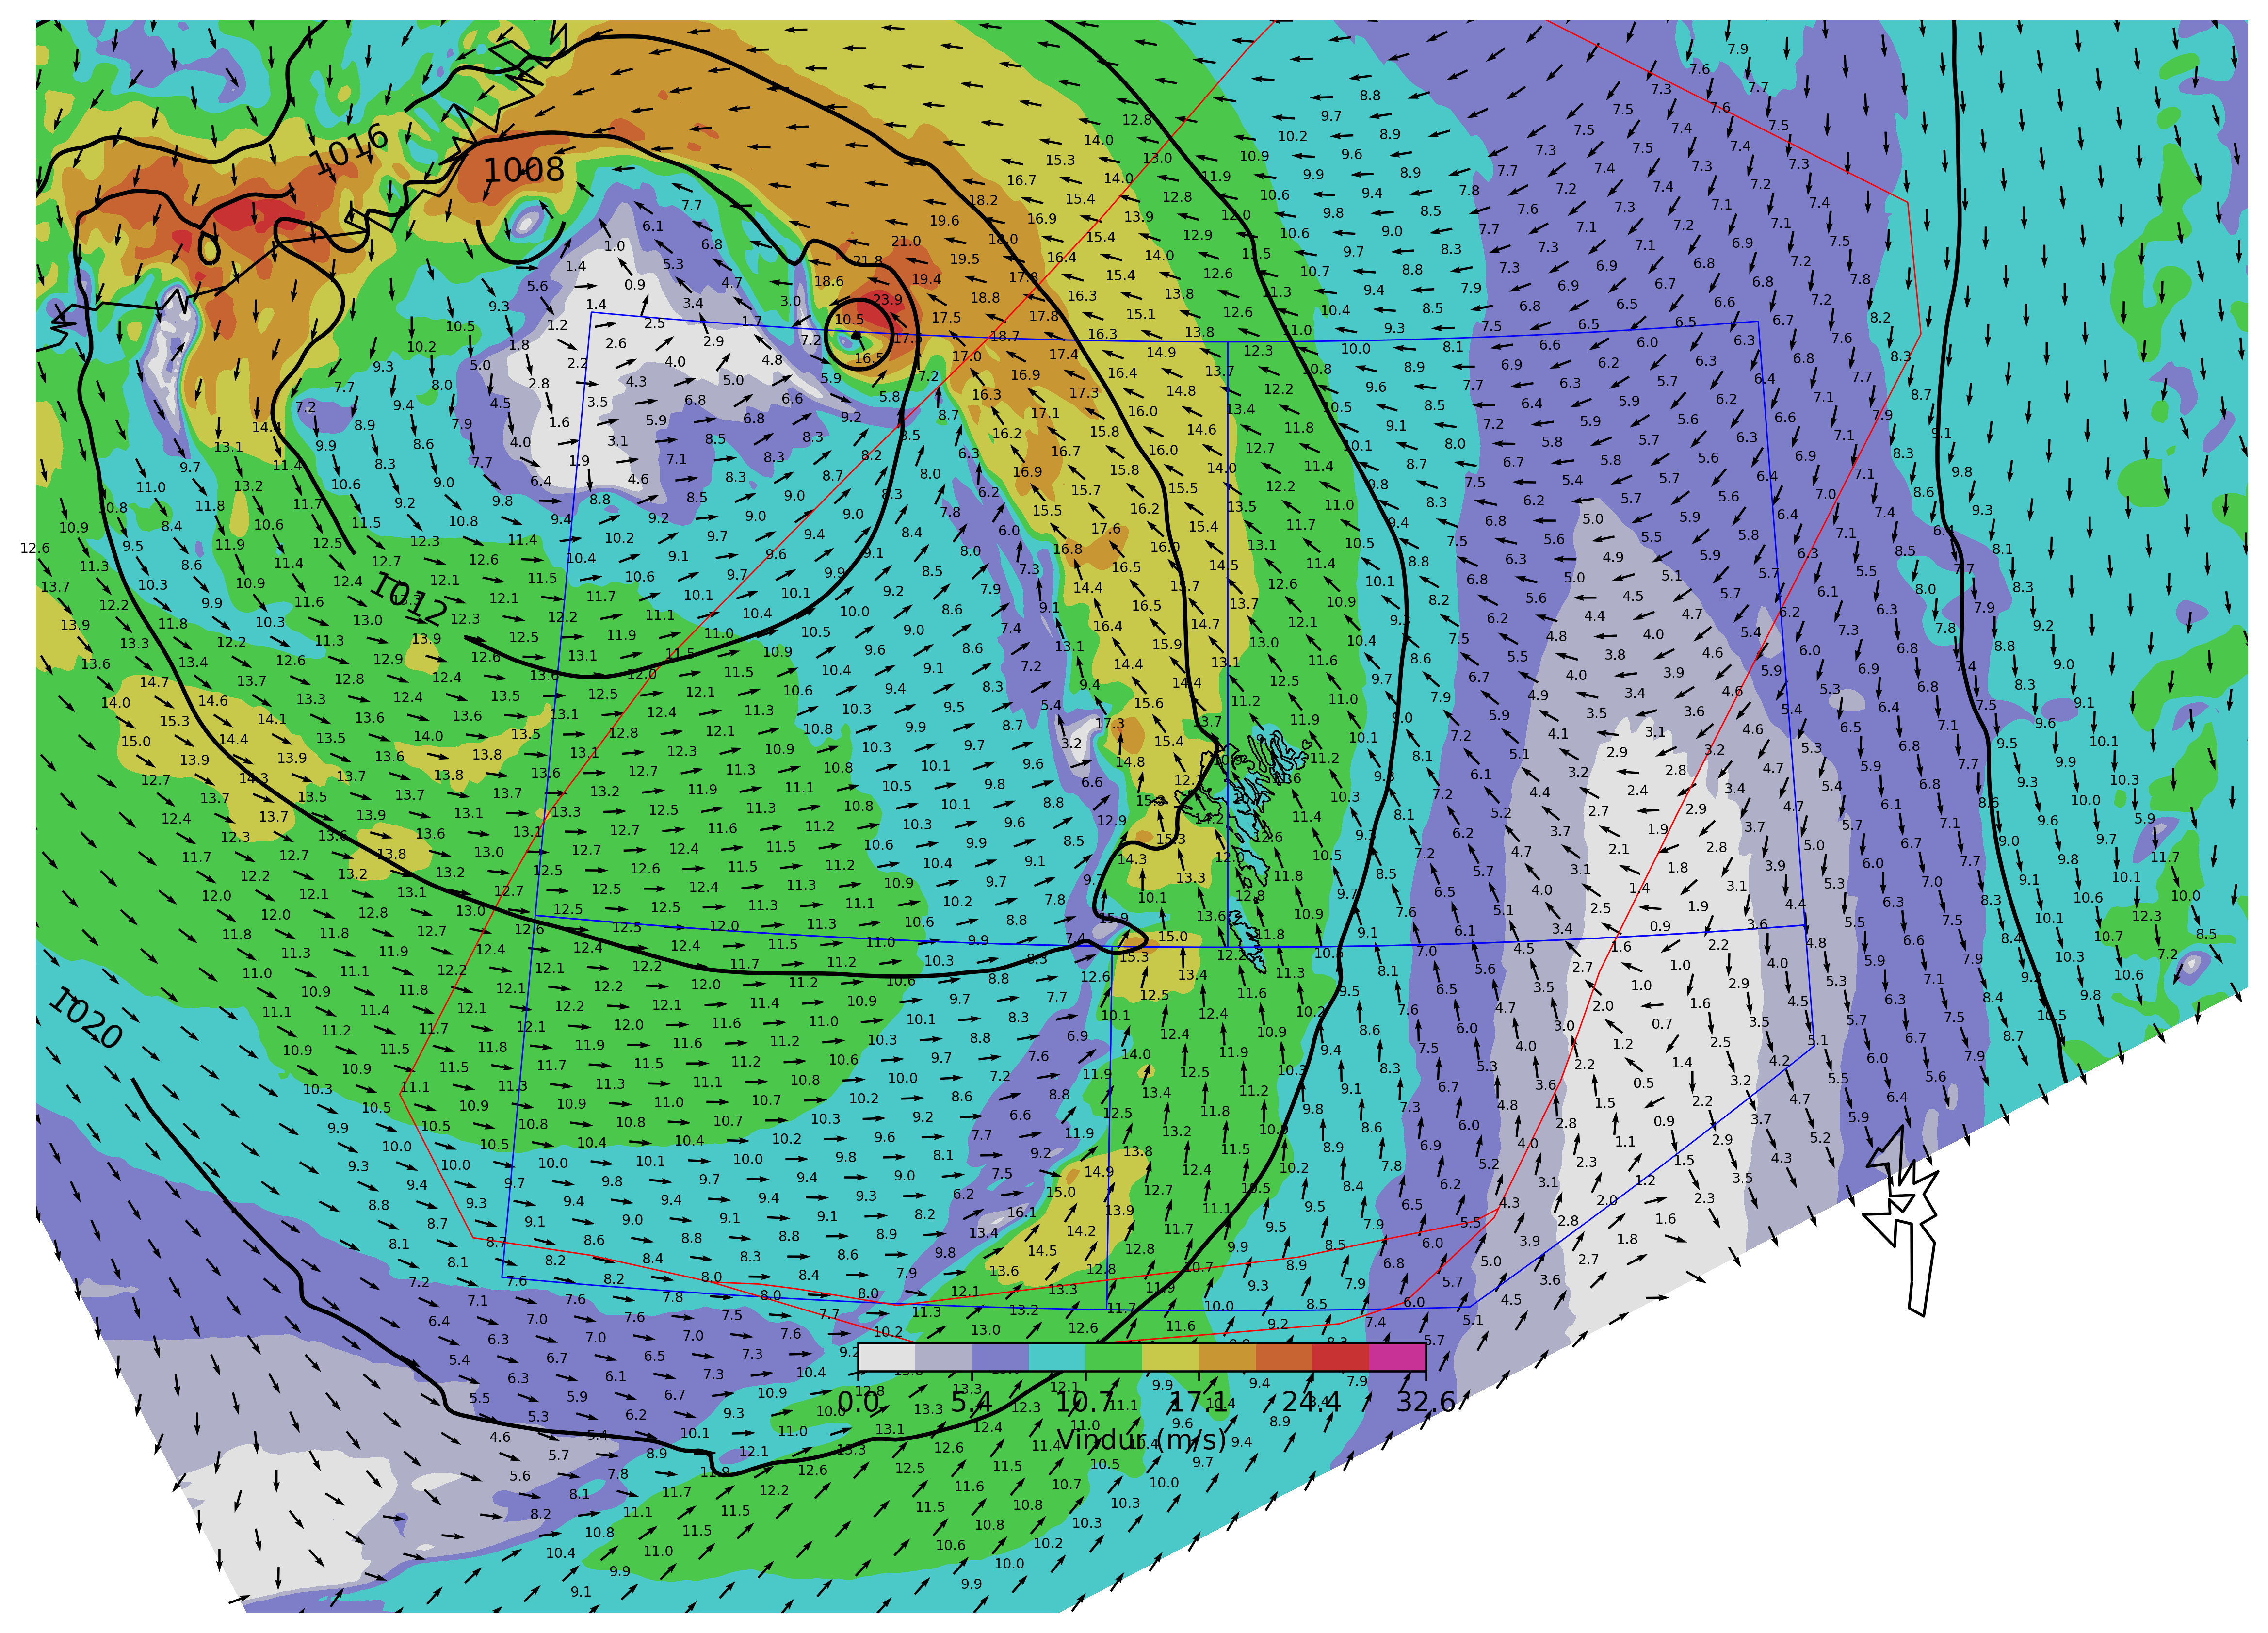

In [129]:
plot_wind(y, x, windspeed, uquiver, vquiver, mslp, SaveFileName)
# plot_clouds(y, x, c1, c2, c3, mslp,temp850,SaveFileName)
# plot_precipitation(y, x, precip, snow, mslp,temp850,SaveFileName)
# plot_visibility(y, x, visibility, mslp,SaveFileName)
# plot_overview(y, x, precip, snow, c1, c2, c3, mslp,temp850,SaveFileName)

In [2]:
SaveFileName = 'OverviewTest.png'
NewSaveFileName = 'OverviewTest_optimized.png'
NewSaveFileName2 = 'OverviewTest_optimized_2.png'

In [3]:
# Filename = 'harmonie-data/NEAData/NEA_2023032709.001'
Filename = 'harmonie-data/NEAData/NEA_2023040409.001'


grbs = pgr.open(Filename)

y, x = grbs.message(191).latlons() #regular lat/lon
u10=grbs.message(191).values
v10=grbs.message(197).values
uquiver=u10/np.sqrt(u10**2+v10**2)*10
vquiver=v10/np.sqrt(u10**2+v10**2)*10
windspeed=np.sqrt(u10**2+v10**2)
c1=grbs.message(215).values
c2=grbs.message(216).values
c3=grbs.message(217).values
t2=grbs.message(181).values-273.15
precip=grbs.message(210).values
snow=grbs.message(225).values
Dir=np.mod(180+np.rad2deg(np.arctan2(u10, v10)),360)
mslp=grbs.message(1).values/100
temp850 = grbs.message(129).values-273.15
visibility = grbs.message(190).values
dewpoint = grbs.message(189).values
maxtemp = grbs.message(187).values-273.15
mintemp = grbs.message(188).values-273.15






In [6]:
print(maxtemp.shape)

(386, 466)


In [27]:
for grb in grbs:
    print(grb)

2:Precipitable water:kg m**-2 (instant):lambert:entireAtmosphere:level 0:fcst time 1 hrs:from 202304040900
3:CAPE out of the model:J kg-1 (instant):lambert:heightAboveGround:level 0:fcst time 1 hrs:from 202304040900
4:165:165 (instant):lambert:heightAboveGround:level 0:fcst time 1 hrs:from 202304040900
5:u-component of wind:m s**-1 (instant):lambert:heightAboveGround:level 100:fcst time 1 hrs:from 202304040900
6:v-component of wind:m s**-1 (instant):lambert:heightAboveGround:level 100:fcst time 1 hrs:from 202304040900
7:Temperature:K (instant):lambert:heightAboveGround:level 100:fcst time 1 hrs:from 202304040900
8:Geometrical height:m (instant):lambert:isothermZero:level 0:fcst time 1 hrs:from 202304040900
9:Geometrical height:m (instant):lambert:unknown:level 26315:fcst time 1 hrs:from 202304040900
10:Graupel:kg m**-2 (accum):lambert:heightAboveGround:level 0:fcst time 0-1 hrs (accum):from 202304040900
11:Latent Heat Sublimation:J kg**-1 (accum):lambert:heightAboveGround:level 0:fcst 

295:Surface roughness:m (instant):lambert:heightAboveGround:level 760:fcst time 1 hrs:from 202304040900
296:Albedo:% (instant):lambert:heightAboveGround:level 800:fcst time 1 hrs:from 202304040900
297:Latent heat flux:W m**-2 (instant):lambert:heightAboveGround:level 0:fcst time 1 hrs:from 202304040900
298:Sensible heat flux:W m**-2 (instant):lambert:heightAboveGround:level 0:fcst time 1 hrs:from 202304040900
299:Momentum flux, u-component:N m**-2 (instant):lambert:heightAboveGround:level 0:fcst time 1 hrs:from 202304040900
300:Momentum flux, v-component:N m**-2 (instant):lambert:heightAboveGround:level 0:fcst time 1 hrs:from 202304040900


In [7]:
from PIL import Image
import datetime


def save_optimized_image(SaveFileName):
    try:
        with Image.open(SaveFileName) as im:
            im_width, im_height = im.size
            im_resize = im.resize((im_width // 3, im_height // 3))

            im_rgb = im_resize.convert('RGB')
            im_rgb.save(f"{NewSaveFileName}", optimize=True, quality=70)
            im_rgb.save(f"{NewSaveFileName2}", optimize=True, quality=70)
    except OSError as e:
        print(e)
        pass


In [8]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# from helpers import save_optimized_image


def generate_waters_plot(y, x):
    plot = Basemap(
        resolution='l',
        projection='stere',
        lat_0=62,
        lon_0=353,
        llcrnrlat=58.4,
        llcrnrlon=-16.41,
        urcrnrlat=65,
        urcrnrlon=3,
    )
    
    plot.drawcoastlines()
    plot.readshapefile('Oyggjar', 'Oyggjar')
    plot.readshapefile('GIS-Files/Ytribanki', 'Ytribanki',color='blue')
    plot.readshapefile('GIS-Files/Munkagrunnur', 'Munkagrunnur',color='blue')
    plot.readshapefile('GIS-Files/Fugloyarbanki', 'Fugloyarbanki',color='blue')
    plot.readshapefile('GIS-Files/Islandsryggur', 'Islandsryggur',color='blue')
    plot.readshapefile('GIS-Files/Fiskimark1','Fiskimark1',color='red')
    plot.readshapefile('GIS-Files/Fiskimark2','Fiskimark2',color='red')
    return plot(x, y)

In [9]:
#Adjusting wind angles
#a, b, and c-side of the triangle
angle = np.ones((386,466))
lon_s = 25
lat_s = -60

#canculating angles
for i in range(386):
    for j in range(466):
        SB = np.sin(np.radians(x[i,j]-lon_s))*np.cos(np.radians(lat_s))
        CB = -np.sin(np.radians(lat_s))*np.cos(np.radians(y[i,j]))+np.cos(np.radians(lat_s))*np.sin(np.radians(y[i,j]))*np.cos(np.radians(x[i,j]-lon_s))
        angle[i,j] = np.rad2deg(np.arctan2(SB,CB))

#adjusting wind-direction with the b-angle
# The constant -9 has to be removed when we figure out how to adjust the angle correctly
direction=np.mod(180+np.rad2deg(np.arctan2(u10, v10)) + angle - 9,360)

#adjusted 10-meter wind speeds (u and v)
u11 = np.sin(np.radians(direction))*windspeed*(-1)
v11 = np.cos(np.radians(direction))*windspeed*(-1)
uquiver = u11 / np.sqrt(u11 ** 2 + v11 ** 2) * 10
vquiver = v11 / np.sqrt(u11 ** 2 + v11 ** 2) * 10


TypeError: 'numpy.int64' object is not iterable

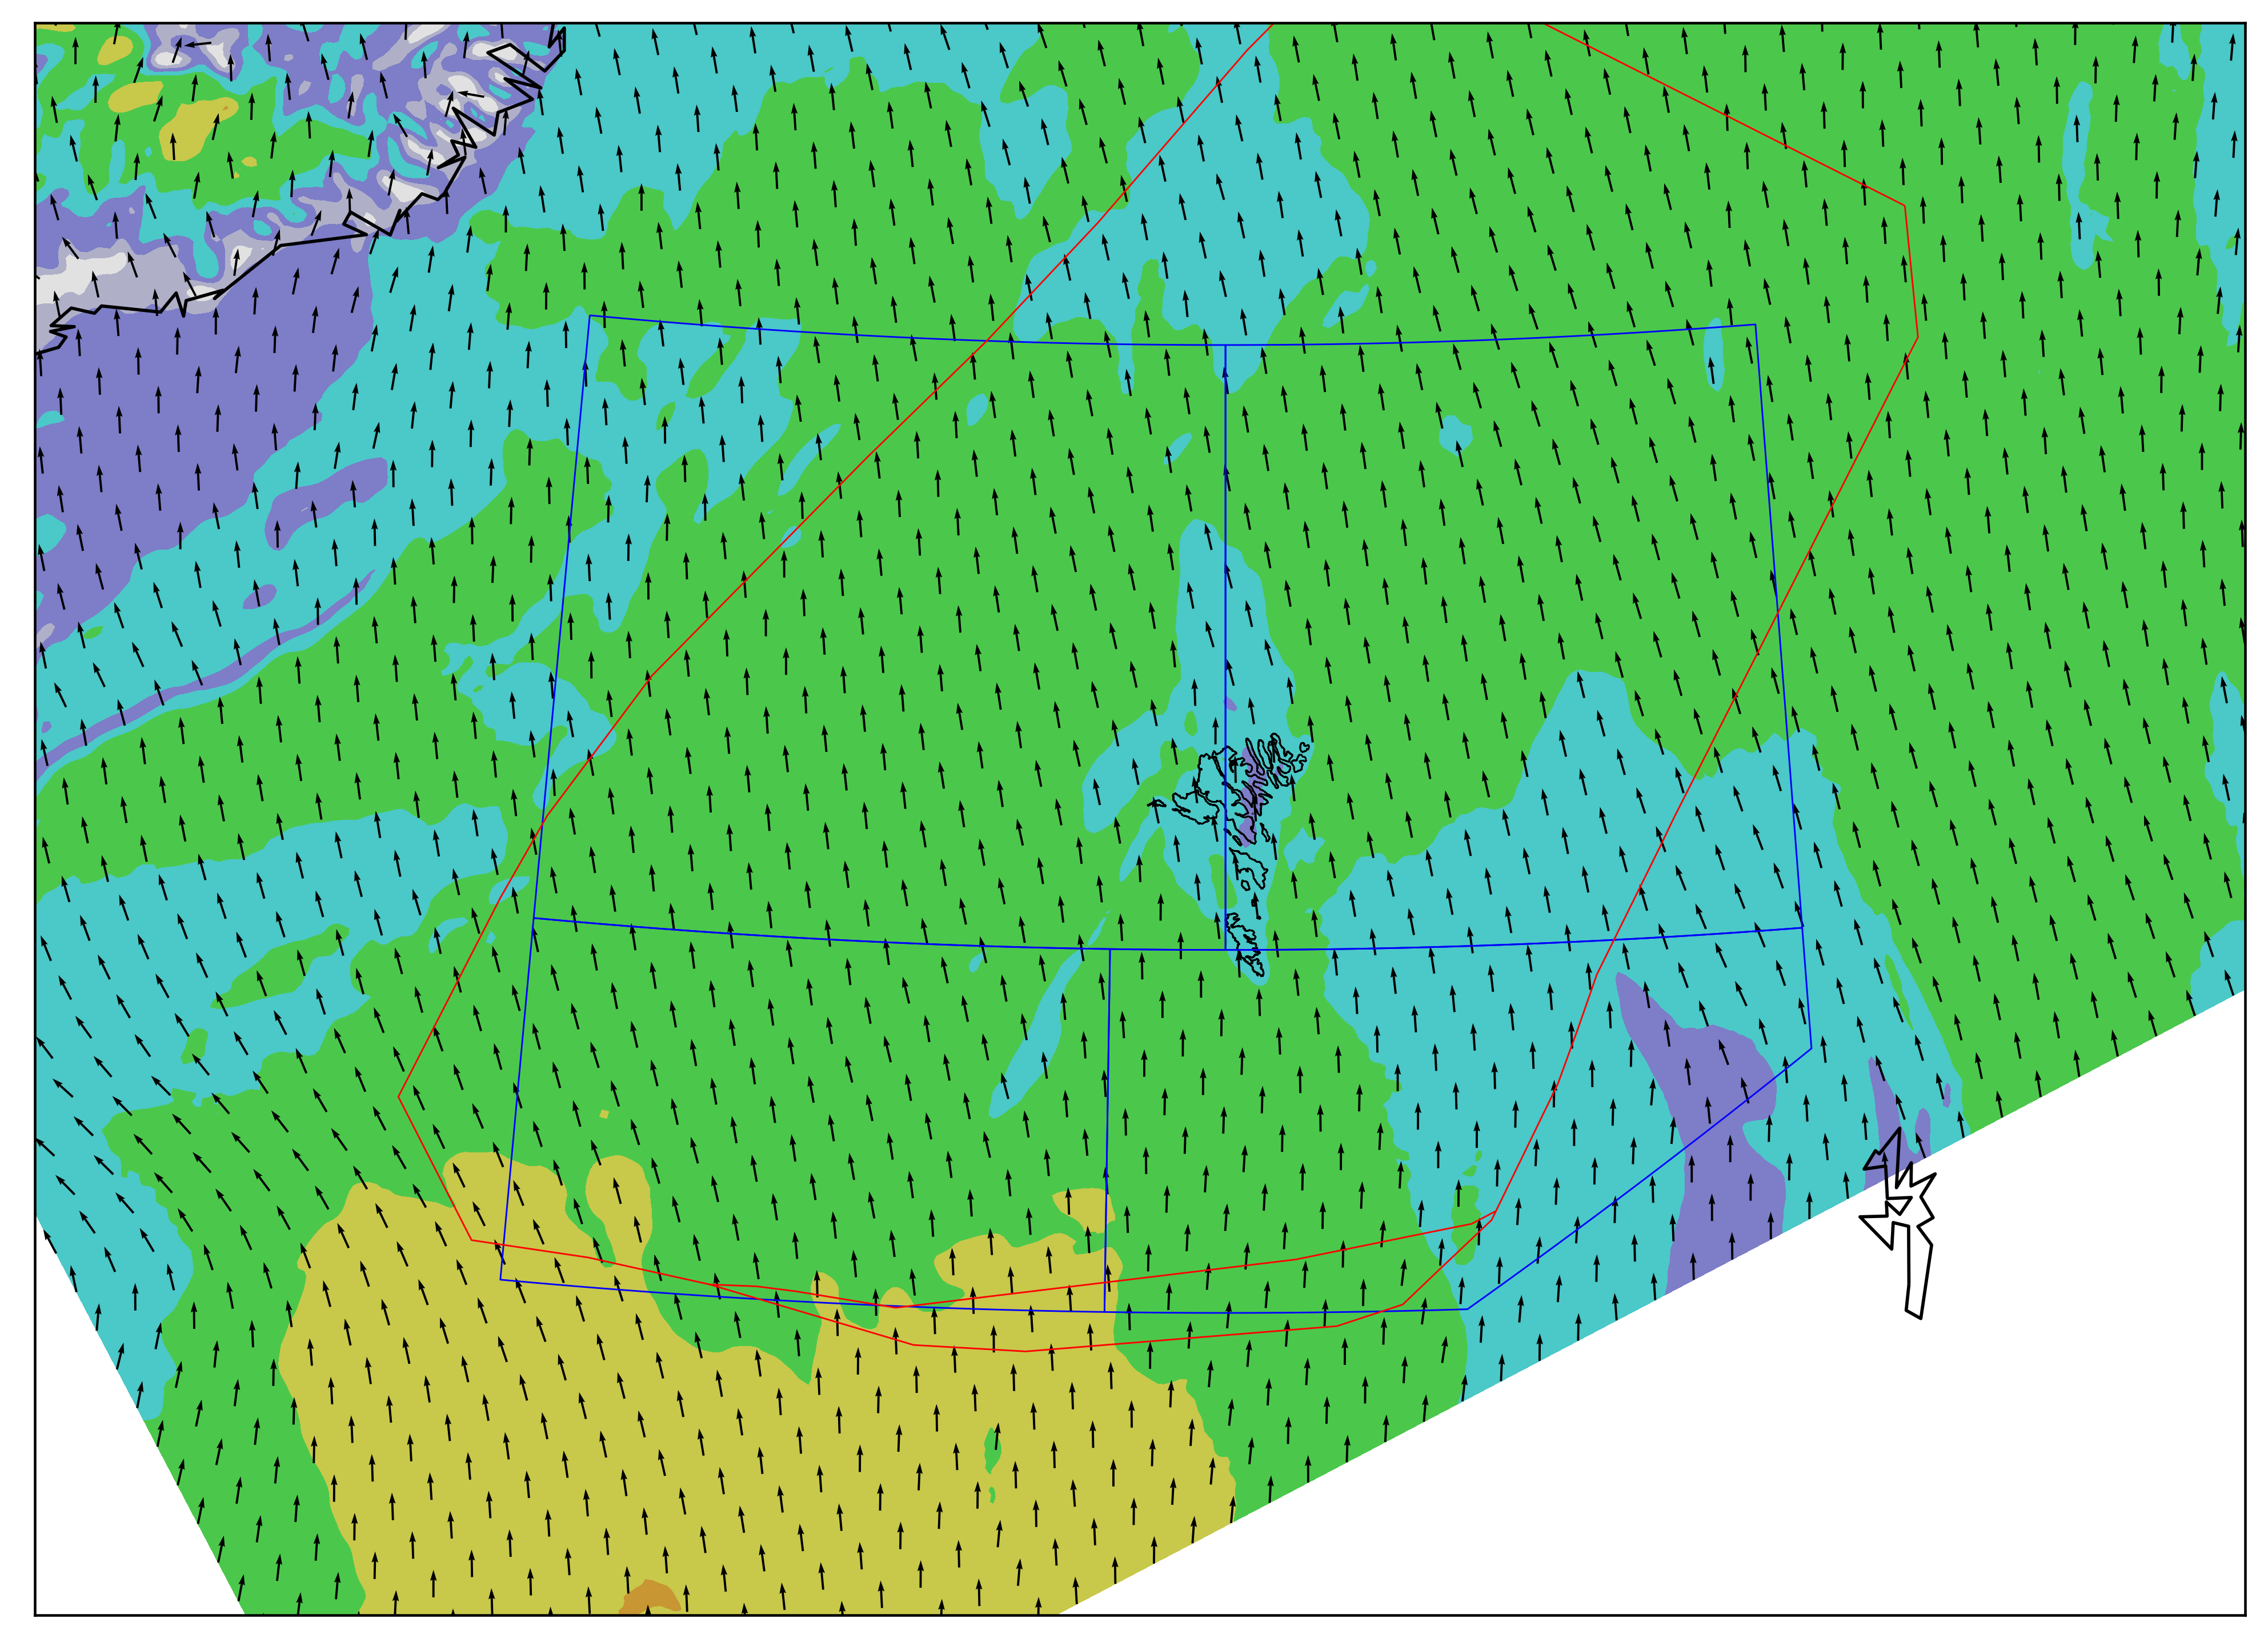

In [13]:
plot_wind(y, x, windspeed, uquiver, vquiver, mslp, SaveFileName)
# plot_clouds(y, x, c1, c2, c3, mslp,temp850,SaveFileName)
# plot_precipitation(y, x, precip, snow, mslp,temp850,SaveFileName)
# plot_visibility(y, x, visibility, mslp,SaveFileName)
# plot_overview(y, x, precip, snow, c1, c2, c3, mslp,temp850,SaveFileName)

In [12]:
def plot_wind(y, x, windspeed, uquiver, vquiver, mslp, SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    levels = [0, 3.3, 5.4, 7.9, 10.7, 13.8, 17.1, 20.7, 24.4, 28.4, 32.6]

    colorstring=[
        '#e1e1e1',
        '#afafc8',
        '#7d7dc8',
        '#4bc8c8',
        '#4bc84b',
        '#c8c84b',
        '#c89632',
        '#c86432',
        '#c83232',
        '#c83296',
        '#9664c8'
    ]

    contour0 = ax.contourf(lons, lats, windspeed, levels=levels,colors=colorstring)
    k = 8
    ax.quiver(
        lons[::k, ::k],
        lats[::k, ::k],
        uquiver[::k, ::k],
        vquiver[::k, ::k],
        color="black",
        scale_units='inches',
        scale=85,
        width=0.0010
    )
    
    ilen = np.floor_divide(386,k)
    jlen = np.floor_divide(386,k)

    for i in range(ilen):
        
        for j in range(jlen):
            
            plt.annotate(windspeed[ilen*k, jlen*k], xy=map(ilen*k,jlen*k))

    ax.axis('off')

    #Printing Colorbar
    cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.2, fraction=0.021, shrink=0.3, orientation='horizontal')
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Vindur (m/s)',size=10)
    
    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)


In [13]:
def plot_clouds(y, x, c1, c2, c3, mslp,temp850,SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    
    #Plotting clouds
    
    #High clouds
    levels = [-0.01, 25, 35, 70, 90, 101]
    colorstring1=['#daf0ff', '#c7c7ff', '#aeaefc', '#9696fa', '#5454ff']
    ax.contourf(lons, lats, c3*100, levels=levels, colors=colorstring1,alpha=0.7)
    
    levels = [35, 55, 70, 95, 101]
    
    #Medium Clouds
    colorstring2=['#c7fa9b', '#b9fa50', '#82fa19', '#7efa19']    
    ax.contourf(lons, lats, c2*100, levels=levels, colors=colorstring2,alpha=0.8)
    
    #Low Clouds
    colorstring3=['#d2d2d2', '#b4b4b4', '#8c8c8c', '#646464']
    contour0 = ax.contourf(lons, lats, c1*100, levels=levels, colors=colorstring3)

    levels = range(800,1100,4)
    contour3 = ax.contour(lons,lats,mslp,levels=levels,colors='black')
    
    
    #Plotting airmass temperature in different color intervals
    levels = range(-40,-6,2)
    contour4 = ax.contour(lons,lats,temp850,levels=levels,colors='#3232e1')
    
    levels = [-4, -2, 0]
    contour5 =ax.contour(lons,lats,temp850,levels=levels,colors='#960096')
    
    levels = range(2,40,2)
    contour6 =ax.contour(lons,lats,temp850,levels=levels,colors='#e13232')
    
    
    ax.axis('off')
    
    #Drawing the colormap of low clouds
    cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.2, fraction=0.021, shrink=0.3, orientation='horizontal')
    cbar.ax.set_xticklabels(['10', '25', '50', '75', '100'])
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Skýloft (%)',size=10)
    
    #Placing text on contour labels
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=True, fontsize=12)
    contourlabel2 = ax.clabel(contour4, contour4.levels, inline=True, fontsize=12)
    contourlabel3 = ax.clabel(contour5, contour5.levels, inline=True, fontsize=12)
    contourlabel4 = ax.clabel(contour6, contour6.levels, inline=True, fontsize=12)

    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)

In [22]:
def plot_visibility(y, x, visibility, mslp,SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    
    #Plotting visibility
    levels = [-0.01, 1000, 4000, 8000, 999999999999]
    colorstring1=['#464646','#964b96', '#e8e248','#daf0ff']
    contour0 = ax.contourf(lons, lats, visibility, levels=levels, colors=colorstring1)
    
    #Plotting pressure
    levels = range(800,1100,4)
    contour3 = ax.contour(lons,lats,mslp,levels=levels,colors='black')
        
    ax.axis('off')
    
    #Drawing the colormap of low clouds
    cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.22, fraction=0.021, shrink=0.3, orientation='horizontal')
    cbar.ax.set_xticklabels(['0km','1km', '4km', '8km', 'Gott sýni'])
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Sýni',size=10)
    
    #Placing text on contour labels
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=True, fontsize=12)


    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)

In [33]:
def plot_precipitation(y, x, precip, snow, mslp,temp850,SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    
    #Plotting rain
    levels = [-0.01, 0.08, 0.17, 0.33, 0.83, 1.67, 4, 8, 15]
    colorstring=['#daf0ff','#8589ff', '#8589ff', '#7275db', '#6568c7', '#4c4fad', '#dbbf6b', '#f5e767']
    contour1 = ax.contourf(lons, lats, precip, levels=levels, colors=colorstring)

    
    #Plotting snow
    levels = [0.17, 0.33, 0.83, 1.67, 2.5, 10]
    colorstring=['#e6d0f2', '#c091d9', '#9a63b8', '#7c419c', '#750c42']
    contour2 = ax.contourf(lons, lats, snow, levels=levels, colors=colorstring)

    levels = range(800,1100,4)
    contour3 = ax.contour(lons,lats,mslp,levels=levels,colors='black')
    
    
    #Plotting airmass temperature in different color intervals
    levels = range(-40,-6,2)
    contour4 = ax.contour(lons,lats,temp850,levels=levels,colors='#3232e1')
    
    levels = [-4, -2, 0]
    contour5 =ax.contour(lons,lats,temp850,levels=levels,colors='#960096')
    
    levels = range(2,40,2)
    contour6 =ax.contour(lons,lats,temp850,levels=levels,colors='#e13232')
    
    
    ax.axis('off')
    
    
    
    cbar2 = plt.colorbar(contour2, ax=ax, extend="neither",location="right", pad=-0.07, fraction=0.021, shrink=0.3, orientation='vertical')
    cbar2.ax.set_yticklabels([0.17, 0.33, 0.83, 1.67, 2.5, 10])
    cbar2.ax.tick_params(labelsize=10)
    cbar2.set_label(label='Kavi (cm/t)',size=10)

    cbar1 = plt.colorbar(contour1, ax=ax, extend="neither",location="right", pad=-0.05, fraction=0.021, shrink=0.3, orientation='vertical')
    cbar1.ax.set_yticklabels([0, 0.08, 0.17, 0.33, 0.83, 1.67, 4, 8, 15])
    cbar1.ax.tick_params(labelsize=10)
    cbar1.set_label(label='Regn (mm/t)',size=10)
    
    #Placing text on contour labels
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=True, fontsize=12)
    contourlabel2 = ax.clabel(contour4, contour4.levels, inline=True, fontsize=12)
    contourlabel3 = ax.clabel(contour5, contour5.levels, inline=True, fontsize=12)
    contourlabel4 = ax.clabel(contour6, contour6.levels, inline=True, fontsize=12)

    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)

In [11]:
def plot_overview(y, x, precip, snow, c1, c2, c3, mslp,temp850,SaveFileName):
    fig, ax = plt.subplots(
        figsize=(21, 9),
        dpi=410.1,
        frameon=False
    )
    lons, lats = generate_waters_plot(y, x)

    #Plotting clouds
    
    levels = [-0.01, 35, 55, 70, 95, 101]
    
    #Low Clouds
    colorstring3=['#daf0ff','#d2d2d2', '#b4b4b4', '#8c8c8c', '#646464']
    contour0 = ax.contourf(lons, lats, c1*100, levels=levels, colors=colorstring3)
    
    #Plotting rain
    levels = [0.08, 0.17, 0.33, 0.83, 1.67, 4, 8, 15]
    colorstring=['#8589ff', '#8589ff', '#7275db', '#6568c7', '#4c4fad', '#dbbf6b', '#f5e767']
    contour1 = ax.contourf(lons, lats, precip, levels=levels, colors=colorstring)

    
    #Plotting snow
    levels = [0.17, 0.33, 0.83, 1.67, 2.5, 10]
    colorstring=['#e6d0f2', '#c091d9', '#9a63b8', '#7c419c', '#750c42']
    contour2 = ax.contourf(lons, lats, snow, levels=levels, colors=colorstring)

    levels = range(800,1100,4)
    contour3 = ax.contour(lons,lats,mslp,levels=levels,colors='black')
    
    
    #Plotting airmass temperature in different color intervals
    levels = range(-40,-6,2)
    contour4 = ax.contour(lons,lats,temp850,levels=levels,colors='#3232e1')
    
    levels = [-4, -2, 0]
    contour5 =ax.contour(lons,lats,temp850,levels=levels,colors='#960096')
    
    levels = range(2,40,2)
    contour6 =ax.contour(lons,lats,temp850,levels=levels,colors='#e13232')
    
    
    ax.axis('off')
    
    
    
    cbar2 = plt.colorbar(contour2, ax=ax, extend="neither",location="right", pad=-0.07, fraction=0.021, shrink=0.3, orientation='vertical')
    cbar2.ax.set_yticklabels([0.17, 0.33, 0.83, 1.67, 2.5, 10])
    cbar2.ax.tick_params(labelsize=10)
    cbar2.set_label(label='Kavi (cm/t)',size=10)

    cbar1 = plt.colorbar(contour1, ax=ax, extend="neither",location="right", pad=-0.47, fraction=0.021, shrink=0.3, orientation='vertical')
    cbar1.ax.set_yticklabels([0.08, 0.17, 0.33, 0.83, 1.67, 4, 8, 15])
    cbar1.ax.tick_params(labelsize=10)
    cbar1.set_label(label='Regn (mm/t)',size=10)
    
    #Drawing the colormap of low clouds
    cbar = plt.colorbar(contour0, ax=ax, extend="neither",location="bottom", pad=-0.2, fraction=0.021, shrink=0.3, orientation='horizontal')
    cbar.ax.set_xticklabels(['0', '10', '25', '50', '75', '100'])
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(label='Skýloft (%)',size=10)
    
    #Placing text on contour labels
    contourlabel1 = ax.clabel(contour3, contour3.levels, inline=True, fontsize=12)
    contourlabel2 = ax.clabel(contour4, contour4.levels, inline=True, fontsize=12)
    contourlabel3 = ax.clabel(contour5, contour5.levels, inline=True, fontsize=12)
    contourlabel4 = ax.clabel(contour6, contour6.levels, inline=True, fontsize=12)

    fig.savefig(SaveFileName, bbox_inches='tight', pad_inches = 0)
    save_optimized_image(SaveFileName)

In [229]:
plot_clouds(y, x, precip, snow, c1, c2, c3, mslp,temp850,SaveFileName)

TypeError: plot_clouds() takes 8 positional arguments but 10 were given